## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

### Install Packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached setuptools-69.5.1-py3-none-any.whl.metadata (6.2 kB)
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
Using cached setuptools-69.5.1-py3-none-any.whl (894 kB)
Using cached wheel-0.43.0-py3-none-any.whl (65 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.42.0
    Uninstalling wheel-0.42.0:
      Successfully uninstalled wheel-0.42.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.2.2
    Uninstalling setuptools-68.2.2:
      Successfully uninstalled setuptools-68.2.2
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Using cached graphviz-0.8.4-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successful

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "agazly"
kaggle_key = "305e94df48b249ca00f112669ac79c39"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Import Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor

import time

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Import Libraries and Dataset

In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [8]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [9]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 2: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [10]:
predictor = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error").fit(
    train_data=train.drop(columns=["casual", "registered"]), time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240421_215433"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240421_215433/ds_sub_fit/sub_fit_ho.
2024-04-21 21:54:33,458	INFO util.py:154 -- Missing packages: ['ipywidgets']. R

### Review AutoGluon's training run with ranking of models that did the best.

In [11]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.008791  root_mean_squared_error      13.954962  369.577864                0.000568           0.030334            3       True         14
1   RandomForestMSE_BAG_L2  -53.292547  root_mean_squared_error      10.118007  312.799872                0.590262          34.293557            2       True         12
2          LightGBM_BAG_L2  -55.000483  root_mean_squared_error       9.756615  294.393404                0.228871          15.887089            2       True         11
3          CatBoost_BAG_L2  -56.929981  root_mean_squared_error       9.561696  302.171414                0.033951          23.665099            2       True         13
4        LightGBMXT_BAG_L2  -60.418489  root_mean_squared_error      13.135261  319.366884   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

In [12]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-53.008791,root_mean_squared_error,13.954962,369.577864,0.000568,0.030334,3,True,14
1,RandomForestMSE_BAG_L2,-53.292547,root_mean_squared_error,10.118007,312.799872,0.590262,34.293557,2,True,12
2,LightGBM_BAG_L2,-55.000483,root_mean_squared_error,9.756615,294.393404,0.228871,15.887089,2,True,11
3,CatBoost_BAG_L2,-56.929981,root_mean_squared_error,9.561696,302.171414,0.033951,23.665099,2,True,13
4,LightGBMXT_BAG_L2,-60.418489,root_mean_squared_error,13.135261,319.366884,3.607516,40.860569,2,True,10
5,KNeighborsDist_BAG_L1,-84.125061,root_mean_squared_error,0.048292,0.048486,0.048292,0.048486,1,True,2
6,WeightedEnsemble_L2,-84.125061,root_mean_squared_error,0.048989,0.073720,0.000698,0.025234,2,True,9
7,KNeighborsUnif_BAG_L1,-101.546199,root_mean_squared_error,0.076793,0.046202,0.076793,0.046202,1,True,1
8,RandomForestMSE_BAG_L1,-116.548359,root_mean_squared_error,0.559144,12.651959,0.559144,12.651959,1,True,5
9,ExtraTreesMSE_BAG_L1,-124.600676,root_mean_squared_error,0.521493,6.174144,0.521493,6.174144,1,True,7


### Create predictions from test dataset

In [13]:
predictions = predictor.predict(test)
predictions.head()

0    22.604462
1    42.220169
2    46.123337
3    48.874306
4    51.882271
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [14]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.599258
std        89.752213
min         3.118577
25%        19.699207
50%        64.137947
75%       167.359634
max       364.592773
Name: count, dtype: float64

In [15]:
# How many negative values do we have?
predictions[predictions < 0].count()

0

In [16]:
# Set them to zero
predictions[predictions < 0] = 0

predictions[predictions < 0].count()

0

### Set predictions to submission dataframe, save, and submit

In [17]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [18]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 480kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [19]:
time.sleep(5)

!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                       date                 description                                                    status    publicScore  privateScore  
-----------------------------  -------------------  -------------------------------------------------------------  --------  -----------  ------------  
submission.csv                 2024-04-21 22:05:32  first raw submission                                           complete  1.80299      1.80299       
submission_new_hpo.csv         2024-04-21 19:34:26  new features (hour, day, month) with hyperparameters (3600ms)  complete  0.74701      0.74701       
submission_new_features.csv    2024-04-21 18:27:18  new features (hour, day, month)                                complete  0.61739      0.61739       
submission.csv                 2024-04-21 17:41:01  first raw submission                                           complete  1.79964      1.79964       


#### Initial score of `1.80299`

## Step 3: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

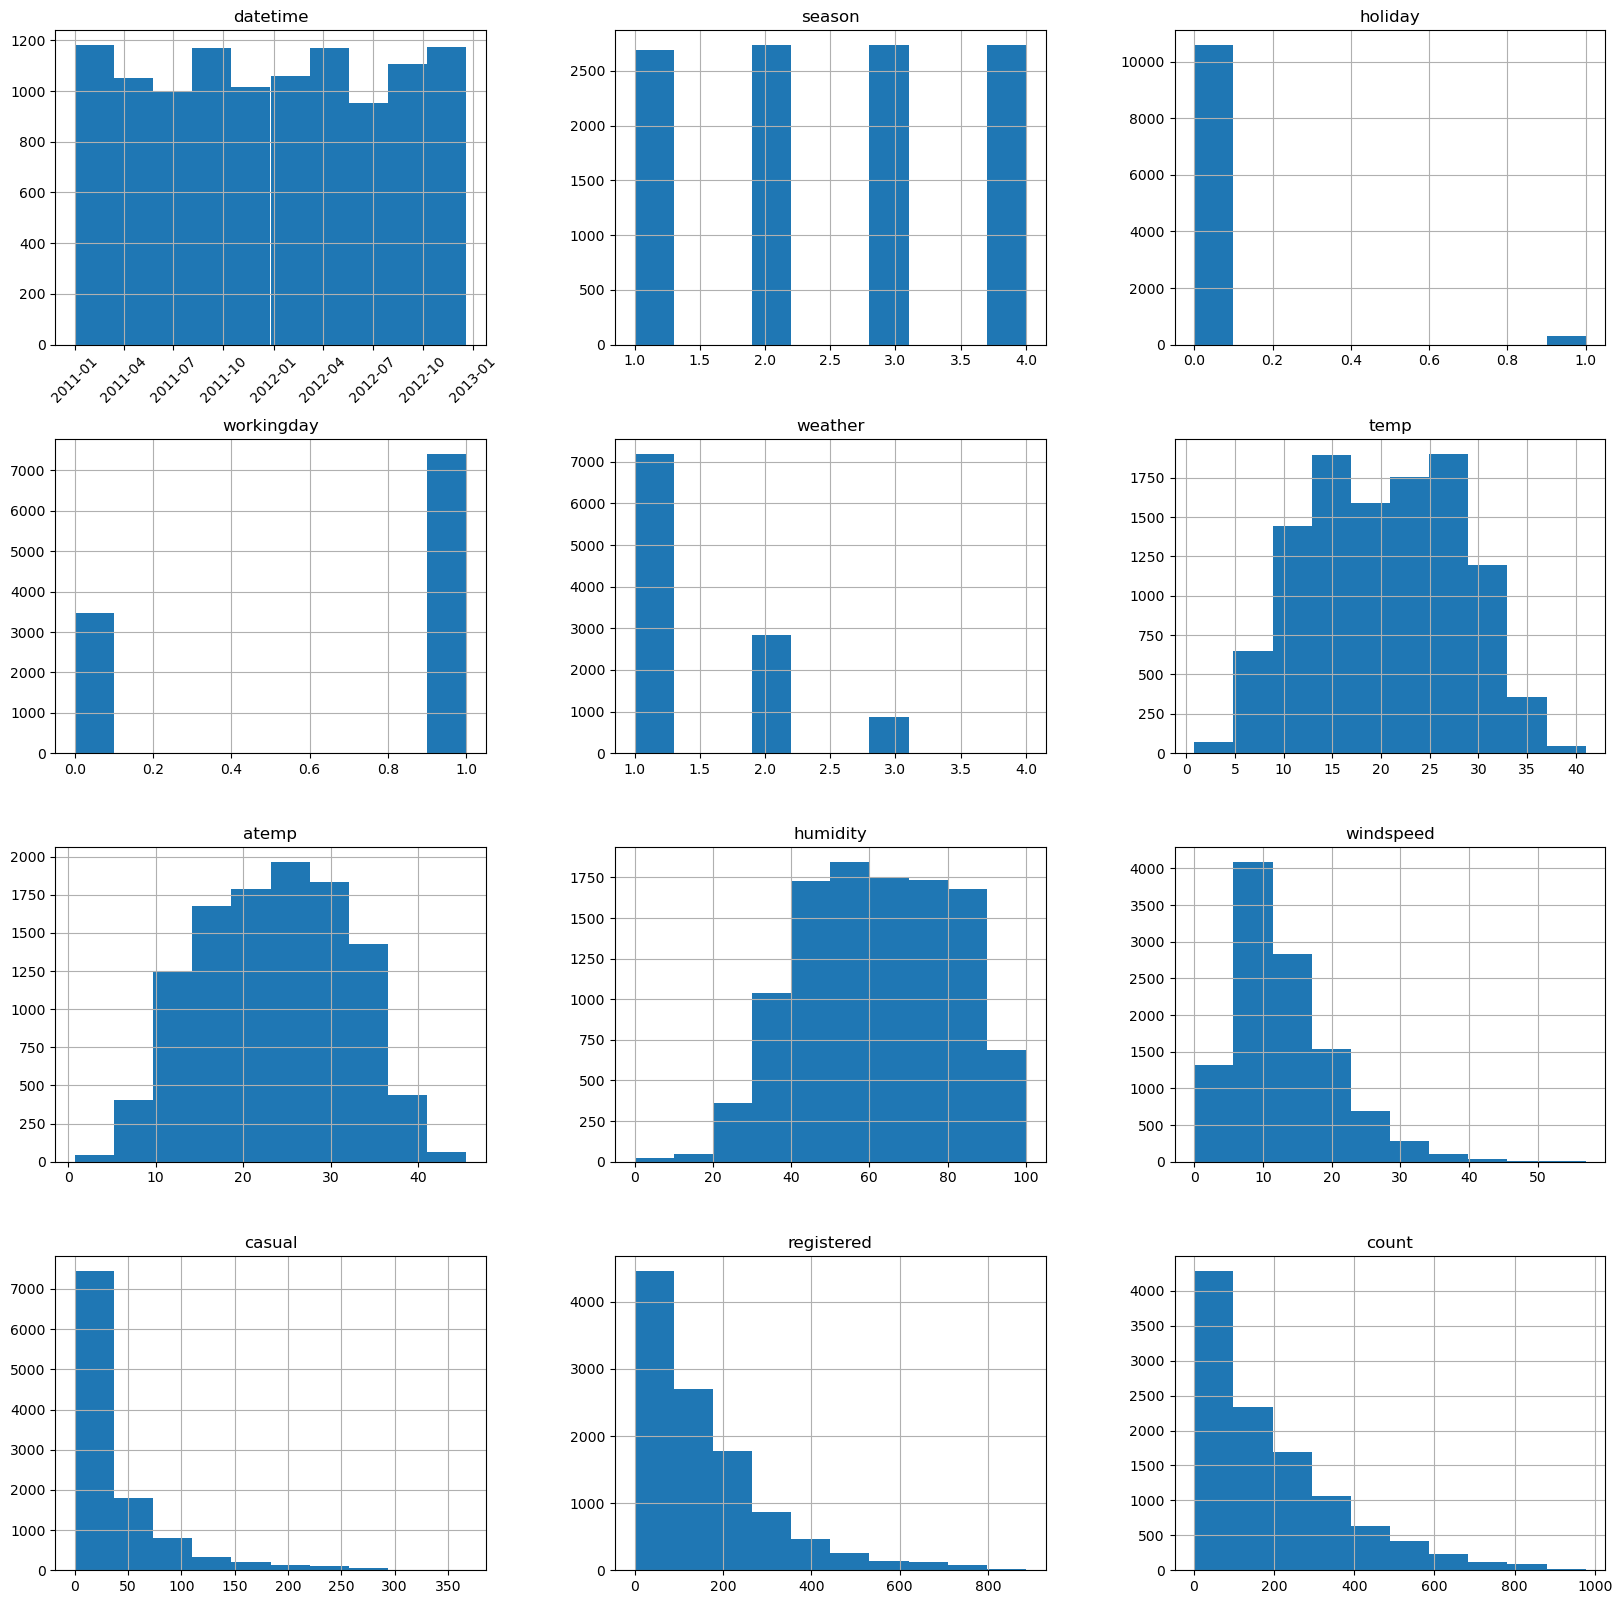

In [20]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20, 20))

# Access the axes objects
axes = plt.gcf().get_axes()

# Set the rotation of the x-axis tick labels for the first histogram
axes[0].tick_params(axis='x', rotation=45)

plt.show()

In [21]:
# create new features
train["hour"] = train["datetime"].dt.hour
train["day"] = train["datetime"].dt.day
train["month"] = train["datetime"].dt.month
train.loc[(train["temp"] < 12) | (train["temp"] > 28), "tempfeel"] = 0
train.loc[(train["temp"] >= 12) & (train["temp"] <= 28), "tempfeel"] = 1
train.loc[(train["humidity"] < 40) | (train["temp"] > 90), "humidityfeel"] = 0
train.loc[(train["humidity"] >= 40) & (train["temp"] <= 90), "humidityfeel"] = 1

test["hour"] = test["datetime"].dt.hour
test["day"] = test["datetime"].dt.day
test["month"] = test["datetime"].dt.month
test.loc[(test["temp"] < 12) | (test["temp"] > 28), "tempfeel"] = 0
test.loc[(test["temp"] >= 12) & (test["temp"] <= 28), "tempfeel"] = 1
test.loc[(test["humidity"] < 40) | (test["temp"] > 90), "humidityfeel"] = 0
test.loc[(test["humidity"] >= 40) & (test["temp"] <= 90), "humidityfeel"] = 1

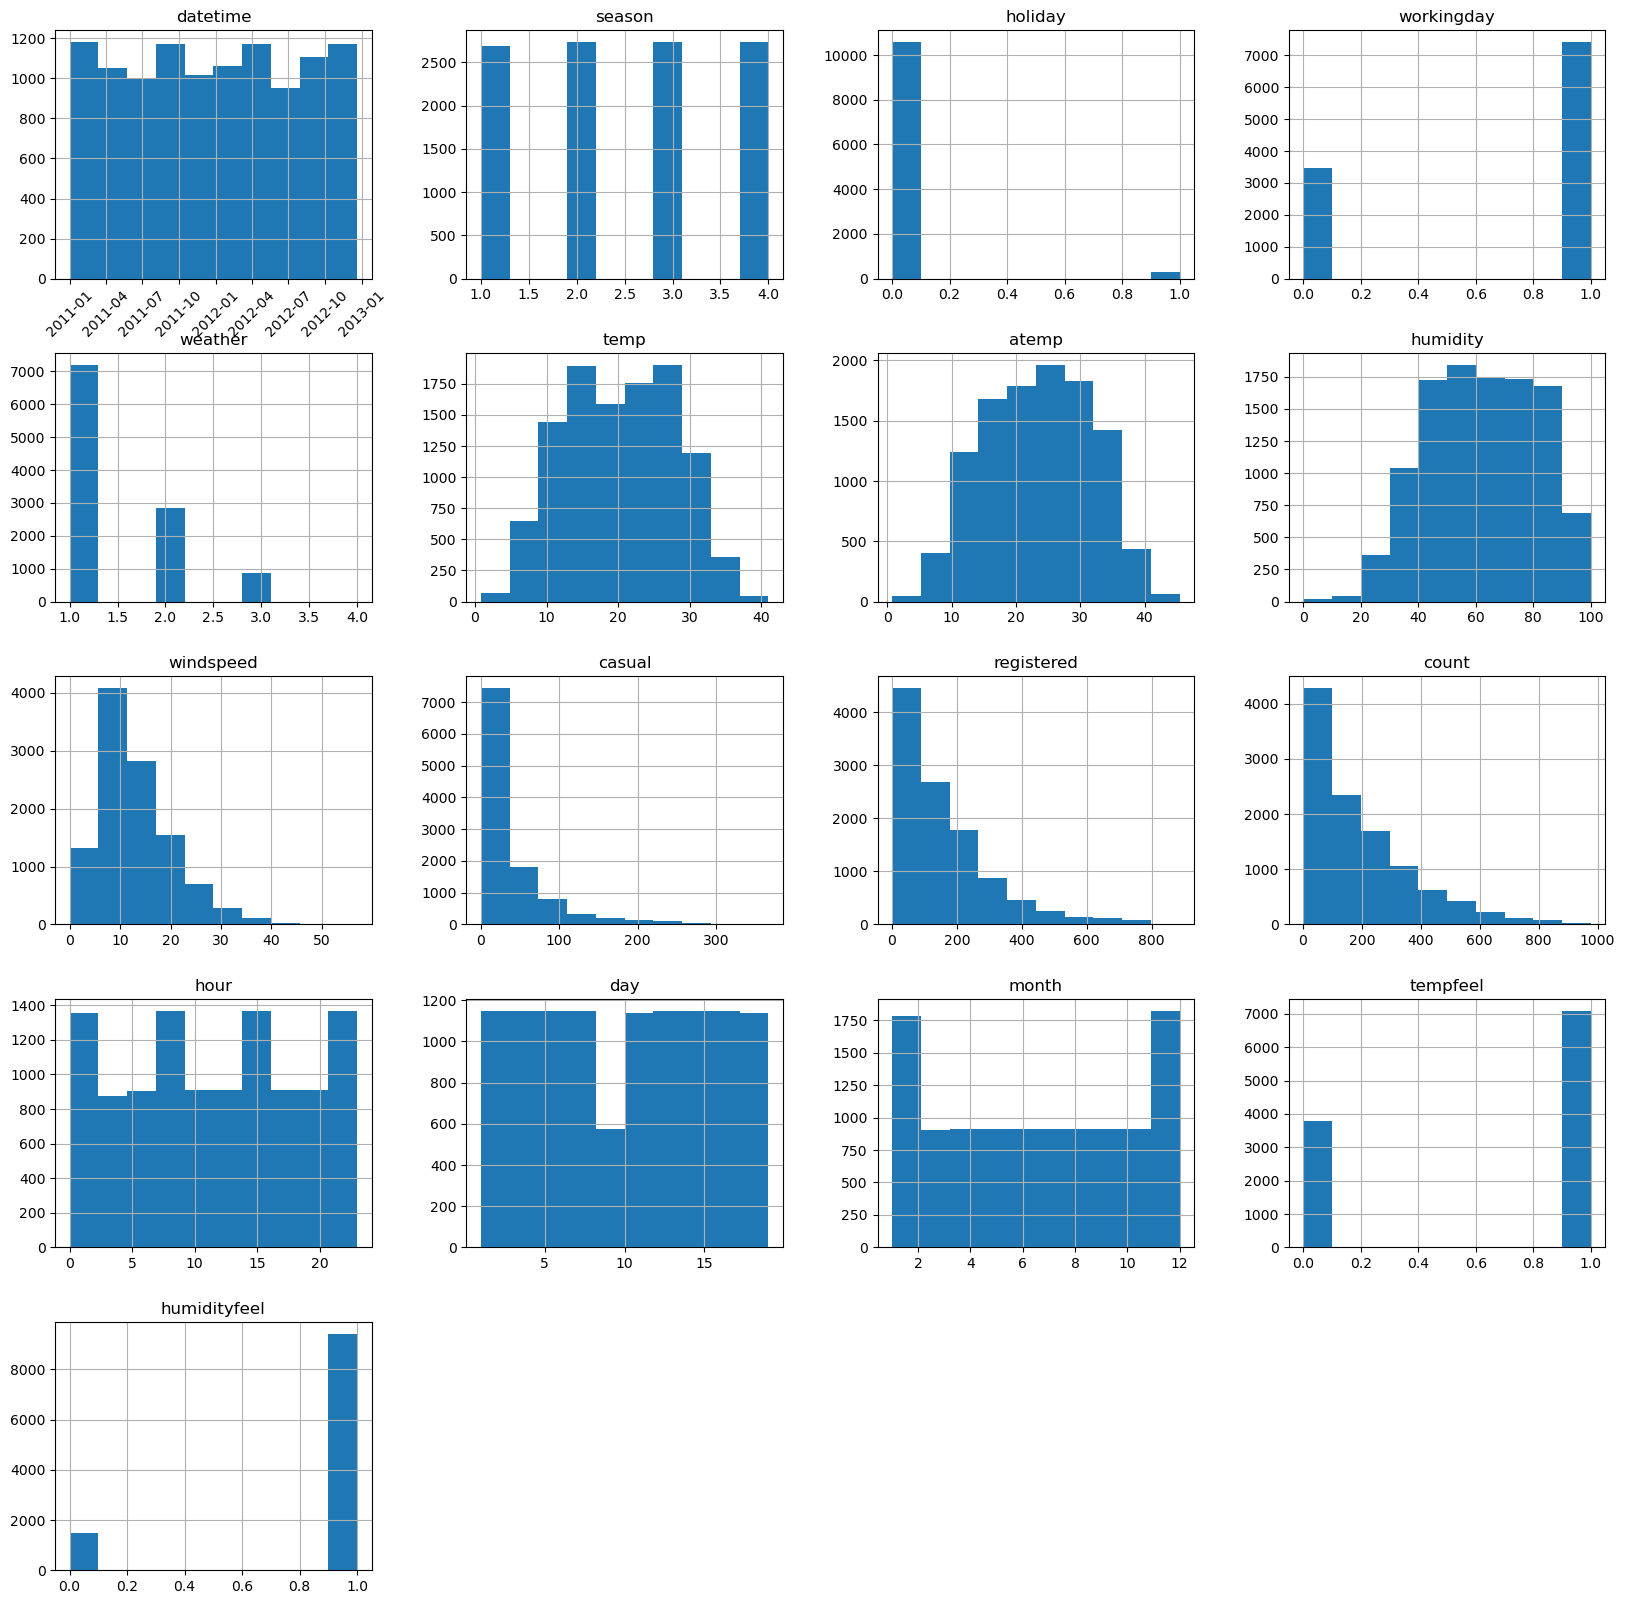

In [22]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20, 20))

# Access the axes objects
axes = plt.gcf().get_axes()

# Set the rotation of the x-axis tick labels for the first histogram
axes[0].tick_params(axis='x', rotation=45)

plt.show()

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [23]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
train["tempfeel"] = train["tempfeel"].astype("category")
train["humidityfeel"] = train["humidityfeel"].astype("category")

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")
test["tempfeel"] = test["tempfeel"].astype("category")
test["humidityfeel"] = test["humidityfeel"].astype("category")

In [24]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,tempfeel,humidityfeel
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,0.0,1.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,0.0,1.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1,0.0,1.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1,0.0,1.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1,0.0,1.0


## Step 4: Rerun the model with the same settings as before, just with more features

In [25]:
predictor_new_features = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error").fit(
    train_data=train.drop(columns=["casual", "registered"]), time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240421_220543"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240421_220543/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 184 seconds

In [26]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.457850  root_mean_squared_error      16.480037  387.784193                0.000566           0.033645            3       True         14
1          LightGBM_BAG_L2  -30.669942  root_mean_squared_error      14.824010  298.398406                0.231421          15.986215            2       True         11
2          CatBoost_BAG_L2  -31.285106  root_mean_squared_error      14.666646  311.887319                0.074058          29.475128            2       True         13
3        LightGBMXT_BAG_L2  -31.309198  root_mean_squared_error      15.566314  303.922181                0.973726          21.509990            2       True         10
4   RandomForestMSE_BAG_L2  -31.719163  root_mean_squared_error      15.200266  320.779214   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.901728605389835,
  'LightGBM_BAG_L1': -33.958363252751994,
  'RandomForestMSE_BAG_L1': -38.3

In [27]:
predictor_new_features.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-30.457850,root_mean_squared_error,16.480037,387.784193,0.000566,0.033645,3,True,14
1,LightGBM_BAG_L2,-30.669942,root_mean_squared_error,14.824010,298.398406,0.231421,15.986215,2,True,11
2,CatBoost_BAG_L2,-31.285106,root_mean_squared_error,14.666646,311.887319,0.074058,29.475128,2,True,13
3,LightGBMXT_BAG_L2,-31.309198,root_mean_squared_error,15.566314,303.922181,0.973726,21.509990,2,True,10
4,RandomForestMSE_BAG_L2,-31.719163,root_mean_squared_error,15.200266,320.779214,0.607677,38.367023,2,True,12
5,WeightedEnsemble_L2,-32.339381,root_mean_squared_error,13.692760,244.703102,0.000582,0.023316,2,True,9
6,LightGBM_BAG_L1,-33.958363,root_mean_squared_error,2.866730,30.408033,2.866730,30.408033,1,True,4
7,CatBoost_BAG_L1,-34.285857,root_mean_squared_error,0.136543,130.149658,0.136543,130.149658,1,True,6
8,LightGBMXT_BAG_L1,-34.901729,root_mean_squared_error,10.085449,68.946221,10.085449,68.946221,1,True,3
9,RandomForestMSE_BAG_L1,-38.346917,root_mean_squared_error,0.556878,15.146757,0.556878,15.146757,1,True,5


In [28]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    14.912298
1     9.710389
2     9.140502
3     7.867320
4     6.958258
Name: count, dtype: float32

In [29]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features < 0] = 0

In [30]:
# Same submitting predictions
submission_new_features = submission.copy(deep=True)
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [31]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 477kB/s]
Successfully submitted to Bike Sharing Demand

In [32]:
time.sleep(5)

!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                       date                 description                                                    status    publicScore  privateScore  
-----------------------------  -------------------  -------------------------------------------------------------  --------  -----------  ------------  
submission_new_features.csv    2024-04-21 22:16:50  new features                                                   complete  0.60979      0.60979       
submission.csv                 2024-04-21 22:05:32  first raw submission                                           complete  1.80299      1.80299       
submission_new_hpo.csv         2024-04-21 19:34:26  new features (hour, day, month) with hyperparameters (3600ms)  complete  0.74701      0.74701       
submission_new_features.csv    2024-04-21 18:27:18  new features (hour, day, month)                                complete  0.61739      0.61739       


#### New Score of `0.60979`

## Step 5: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [34]:
predictor_new_hpo = TabularPredictor(label="count", problem_type="regression", eval_metric="root_mean_squared_error").fit(
    train_data=train.drop(columns=["casual", "registered"]), time_limit=3600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240421_223706"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 3600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240421_223706/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 939 second

In [35]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                        model   score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3  -28.989171  root_mean_squared_error      21.583298  2162.225099                0.002206           0.069844            3       True         25
1      NeuralNetFastAI_BAG_L2  -29.206753  root_mean_squared_error      20.739276  1839.693995                0.440400         106.484467            2       True         19
2             CatBoost_BAG_L2  -30.187968  root_mean_squared_error      20.409730  1913.508879                0.110855         180.299351            2       True         17
3        CatBoost_r177_BAG_L2  -30.432014  root_mean_squared_error      20.399534  1801.090777                0.100658          67.881249            2       True         23
4             LightGBM_BAG_L2  -30.484820  root_mean_squared_error      2

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_

In [36]:
predictor_new_hpo.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-28.989171,root_mean_squared_error,21.583298,2162.225099,0.002206,0.069844,3,True,25
1,NeuralNetFastAI_BAG_L2,-29.206753,root_mean_squared_error,20.739276,1839.693995,0.440400,106.484467,2,True,19
2,CatBoost_BAG_L2,-30.187968,root_mean_squared_error,20.409730,1913.508879,0.110855,180.299351,2,True,17
3,CatBoost_r177_BAG_L2,-30.432014,root_mean_squared_error,20.399534,1801.090777,0.100658,67.881249,2,True,23
4,LightGBM_BAG_L2,-30.484820,root_mean_squared_error,20.625764,1752.657860,0.326888,19.448332,2,True,15
5,XGBoost_BAG_L2,-30.936992,root_mean_squared_error,20.538550,1759.804949,0.239674,26.595421,2,True,20
6,LightGBMXT_BAG_L2,-30.986018,root_mean_squared_error,21.161735,1755.078243,0.862859,21.868716,2,True,14
7,LightGBMLarge_BAG_L2,-31.099023,root_mean_squared_error,20.746340,1769.680722,0.447464,36.471195,2,True,22
8,ExtraTreesMSE_BAG_L2,-31.411604,root_mean_squared_error,20.927506,1746.288334,0.628630,13.078806,2,True,18
9,RandomForestMSE_BAG_L2,-31.481751,root_mean_squared_error,20.941962,1783.829466,0.643086,50.619938,2,True,16


In [37]:
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    13.356457
1     6.573179
2     5.677102
3     6.346796
4     6.316926
Name: count, dtype: float32

In [38]:
# Remember to set all negative values to zero
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [39]:
# Same submitting predictions
submission_new_hpo = submission.copy(deep=True)
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [40]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 301kB/s]
Successfully submitted to Bike Sharing Demand

In [43]:
time.sleep(5)

!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                       date                 description                                                    status    publicScore  privateScore  
-----------------------------  -------------------  -------------------------------------------------------------  --------  -----------  ------------  
submission_new_hpo.csv         2024-04-21 23:41:05  new features with hyperparameters                              complete  0.7497       0.7497        
submission_new_features.csv    2024-04-21 22:16:50  new features                                                   complete  0.60979      0.60979       
submission.csv                 2024-04-21 22:05:32  first raw submission                                           complete  1.80299      1.80299       
submission_new_hpo.csv         2024-04-21 19:34:26  new features (hour, day, month) with hyperparameters (3600ms)  complete  0.74701      0.74701       


#### New Score of `0.7497`

## Step 6: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

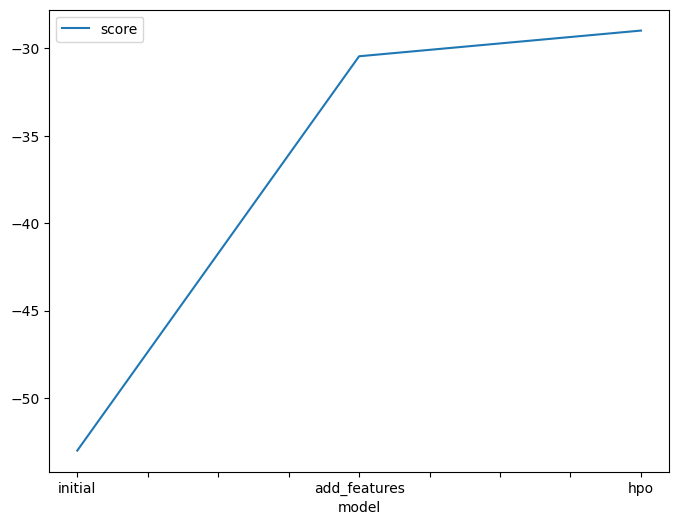

In [44]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.008791, -30.457850, -28.989171]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

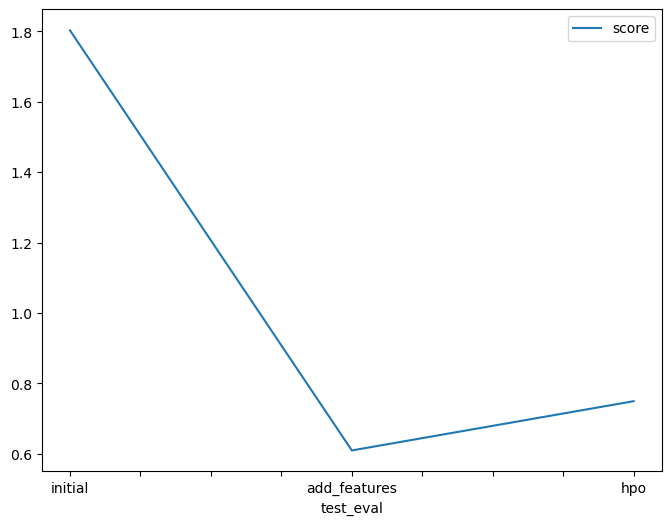

In [45]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80299, 0.60979, 0.7497]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [46]:
# The 3 hyperparameters we tuned with the kaggle score as the result
# hpo1: eval_metric
# hpo2: time_limit
# hpo3: presets
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['root_mean_squared_error', 'root_mean_squared_error', 'root_mean_squared_error'],
    "hpo2": [600, 600, 3600],
    "hpo3": ["best_quality", "best_quality", "best_quality"],
    "score": [1.80299, 0.60979, 0.7497]
})

,model,hpo1,hpo2,hpo3,score
0,initial,root_mean_squared_error,600,best_quality,1.80299
1,add_features,root_mean_squared_error,600,best_quality,0.60979
2,hpo,root_mean_squared_error,3600,best_quality,0.74970
